# DATA 335 - Winter 2025 - Lab 6

## Logistic regression: complete separation

2025.03.11, 14:00-15:50, MS 521

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import bambi as bmb
import arviz as az

Here is a function to load in classes 0 and 1 of the three class iris classification dataset that ships with Scikit-Learn:

In [28]:
def load_iris_01():
    X, y = load_iris(return_X_y=True, as_frame=True)
    indices = np.logical_or(y == 0, y == 1)
    X = X[indices]
    y = y[indices]
    return X, y

**To do:** Fit a Scikit-Learn logistic regression model (`sklearn.linear_model.LogisticRegression`) to the two-class iris data with `penalty` set to `None`. Verify that the training accuracy score (`sklearn.metrics.accuracy_score`) is `1.0`.

In [30]:
X, y = load_iris_01()

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


**To do:** Try using statsmodels to fit a logistic regression model (`statsmodels.api.Logit`) to the data. Expect warnings about "perfect separation" or "possibly complete quasi-separation". Note the sizes of the standard errors in the fit object returned by `Logit.fit`.

Logistic regression models are fit by trying to find the coefficient vectors $c$ that minimize **log-loss**:
$$
\min_c L(c)
\tag{$*$}
$$
where
$$
L(c) = - \frac1n\sum_{i<n}\left(y_i\log\sigma(c\cdot x_i) +  (1 - y_i)\log(1 - \sigma(c\cdot x_i))\right)
$$

When the classes are linearly separable &mdash; there's a hyperplane in features space with all of class 0 on one side and all of class 1 on the other &mdash; then ($*$) has no solution.

In what follows, we'll figure out why this is.

The iris dataset has a 4-dimensional feature space. Let's take a step back and consider the 1-dimensional case.

Here's a construction of a classification dataset with a single feature $x$ and perfect separation according to whether $x>0$ or $x<0$:

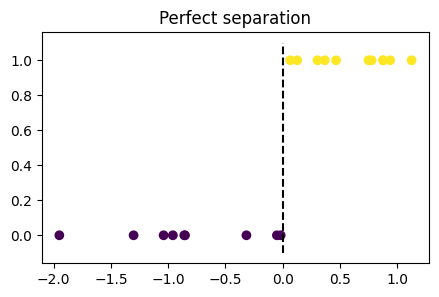

In [14]:
n = 20
rng = np.random.default_rng(42)
x = rng.normal(size=n)
X = x.reshape(-1, 1)
y = x > 0

plt.figure(figsize=(5, 3))
plt.scatter(x, y, c=y)
u = np.linspace(*plt.xlim(), 100)
plt.plot([0, 0], [-0.1, 1.1], "k--")
plt.title("Perfect separation")
plt.show()

Consider fitting a logistic regression model **without intercept** to this dataset, i.e., minimizing
$$
L(c) = - \frac1n\sum_{i<n}\left(y_i\log\sigma(c x_i) +  (1 - y_i)\log(1 - \sigma(c x_i))\right).
$$
over numbers $c$.

**To do:** Plot $L(c)$ versus $c$ for an evenly-spaced grid of 100 values between 0 and 20. What do you observe?

Feel free to use Scikit-Learn's built-in log-loss function, `sklearn.metrics.log_loss`.

The **sigmoid** or **expit** function $\sigma$ is available through the Scipy package as `scipy.special.expit`. It's defined by
$$
\sigma(u) = \frac1{1 + e^{-u}}.
$$

Since
$$
y_i = 0\Longleftrightarrow x_i < 0\quad\text{and}
y_i = 1\Longleftrightarrow x_i > 0,
$$
we have
$$
L(c) = -\frac1n\left\{\sum_{i\,:\,x_i > 0} \log\sigma(cx_i) + \sum_{i\,:\,x_i < 0} \log(1 - \sigma(cx_i))\right\}
$$

**To do:** For each $i$ with $x_i > 0$ (resp., $x_i < 0$), plot $\log\sigma(cx_i)$ (resp. $\log(1 - \sigma(cx_i))$) versus $c$ on the left panel (resp., right panel) of the plot in the cell below. 

You should observe that each term in the sum for $L(c)$ decays to $0$ as $c\to\infty$.

**To do:** *Prove* that each term in the sum for $L(c)$ decays to $0$ as $c\to\infty$. Proceed as follows, using the definition of $\sigma$ together with properties of exponentials and logarithms:

- Explain why
  $$
  \lim_{u\to\infty} \log\sigma(u) = 0.
  $$

- Conclude that if $x > 0$, then
  $$
  \lim_{c\to\infty} \log\sigma(cx) = 0.
  $$

- Explain why
  $$
  \lim_{u\to-\infty} \log(1 - \sigma(u)) = 0.
  $$

- Conclude that if $x < 0$, then
  $$
  \lim_{c\to\infty} \log(1 - \sigma(cx)) = 0.
  $$

- Conclude that
  $$
  \lim_{c\to\infty} L(c) = 0
  $$


Now let's return to the two-class iris dataset.

Using Scikit-Learn's logistic regression, we extract a hyperplane $v_0\cdot x = 0$ that separates class 0 from class 1 in 4-dimensional feature space:

In [26]:
X, y = load_iris_01()

model = LogisticRegression(penalty=None, fit_intercept=False)
model.fit(X, y)
assert accuracy_score(y, model.predict(X)) == 1

v0 = model.coef_.squeeze()
print(f"v0 = {v0}")

assert np.all(X[y == 0] @ v0 < 0)
assert np.all(X[y == 1] @ v0 > 0)

v0 = [-1.26145424 -4.44578623  6.60584726  3.20483996]


**To do:** Plot $L(cv_0)$ versus $c$ for an evenly-spaced grid of 100 values between 0 and 1. What do you observe?

**To do:** Prove that
$$
\lim_{c\to\infty} L(cv_0) = 0.
$$

Hint: Reduce to the 1-dimensional case (analyzed above) by letting $z_i = v_0\cdot x_i$.

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Bayesian logistic regression

Let's try fitting a Bayesian logistic regression model to the two-class iris dataset using Bambi:

In [39]:
X, y = load_iris_01()

df = X.rename(
    columns={
        "sepal length (cm)": "sl",
        "sepal width (cm)": "sw",
        "petal length (cm)": "pl",
        "petal width (cm)": "pw",
    }
)
df["label"] = y

model = bmb.Model("label ~ sl + sw + pl + pw", df, family="bernoulli")
display(model)
fit = model.fit()
az.summary(fit)

       Formula: label ~ sl + sw + pl + pw
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            sl ~ Normal(mu: 0.0, sigma: 1.5662)
            sw ~ Normal(mu: 0.0, sigma: 2.0993)
            pl ~ Normal(mu: 0.0, sigma: 0.6933)
            pw ~ Normal(mu: 0.0, sigma: 1.7783)

Modeling the probability that label==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sl, sw, pl, pw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.103,6.650,-17.250,7.423,0.108,0.088,3810.0,3186.0,1.0
sl,1.424,1.212,-0.700,3.855,0.021,0.017,3230.0,2610.0,1.0
sw,-2.705,1.338,-5.109,-0.101,0.024,0.018,3202.0,2805.0,1.0
pl,1.205,0.585,0.098,2.274,0.010,0.008,3352.0,2762.0,1.0
pw,3.036,1.440,0.240,5.556,0.024,0.017,3497.0,2524.0,1.0


Standard errors look ok, and accuracy score of 1.0.

**To do:** Why didn't Bambi have an issue with the perfect separability like statsmodels did?

In [41]:
model.predict(fit, data=df)
assert accuracy_score(df["label"], fit.posterior["p"].mean(axis=(0, 1)) > 0.5)

**To do:** How small can you set the `sigma` parameter on the priors for the Bambi model before prediction accuracy starts to suffer?

In [45]:
sigma = 0.1

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=sigma),
    "sl": bmb.Prior("Normal", mu=0, sigma=sigma),
    "sw": bmb.Prior("Normal", mu=0, sigma=sigma),
    "pl": bmb.Prior("Normal", mu=0, sigma=sigma),
    "pw": bmb.Prior("Normal", mu=0, sigma=sigma),
}

model = bmb.Model("label ~ sl + sw + pl + pw", df, family="bernoulli", priors=priors)
fit = model.fit()
model.predict(fit, data=df)
assert accuracy_score(df["label"], fit.posterior["p"].mean(axis=(0, 1)) > 0.5) == 1.0

Modeling the probability that label==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sl, sw, pl, pw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
